In [ ]:
# from transformers import AutoTokenizer

# model_path="meta-llama/Llama-2-7b-chat-hf"

# # Load the LLaMA 2 tokenizer (assuming it's already available via Hugging Face)
# tokenizer = AutoTokenizer.from_pretrained(model_path)

# # Sample text prompt
# prompt = "This is an example text to count the tokens."

# # Tokenize the prompt
# tokens = tokenizer.encode(prompt, return_tensors="pt")

# # Count the number of tokens
# token_count = tokens.shape[1]

# print(f"Number of tokens: {token_count}")

In [1]:
# read json
import json
import os
import sys
from tqdm import tqdm

In [3]:
with open('/data/yedasong/sysproj_data/ShareGPT_V3_unfiltered_cleaned_split.json', 'r') as f:
    sharegpt_data = json.load(f)

len(sharegpt_data)

94145

In [4]:
from transformers import LlamaTokenizer
from collections import Counter
import json
from typing import List, Dict
import pandas as pd

def analyze_token_frequencies(data: List[Dict], model_name: str = "meta-llama/Llama-2-7b-hf") -> pd.DataFrame:
    """
    Tokenize conversation data using Llama tokenizer and analyze token frequencies.

    Args:
        data: List of dictionaries containing conversation data
        model_name: Name of the Llama model to use for tokenization

    Returns:
        DataFrame with token frequencies sorted from highest to lowest
    """
    # Initialize tokenizer
    tokenizer = LlamaTokenizer.from_pretrained(model_name)

    # Extract all conversation texts
    all_texts = []
    for item in data:
        for conv in item['conversations']:
            all_texts.append(conv['value'])

    # Combine all texts
    combined_text = " ".join(all_texts)

    # Tokenize the text
    tokens = tokenizer.encode(combined_text, add_special_tokens=True)

    # Convert token IDs back to tokens
    token_strings = [tokenizer.decode([token]) for token in tokens]

    # Count frequencies
    token_frequencies = Counter(token_strings)

    # Convert to DataFrame and sort
    freq_df = pd.DataFrame.from_dict(token_frequencies, orient='index', columns=['frequency'])
    freq_df.index.name = 'token'
    freq_df = freq_df.sort_values('frequency', ascending=False)

    # Add percentage column
    total_tokens = freq_df['frequency'].sum()
    freq_df['percentage'] = (freq_df['frequency'] / total_tokens * 100).round(2)

    return freq_df

def save_frequency_analysis(freq_df: pd.DataFrame, output_path: str = "token_frequencies.csv"):
    """
    Save the frequency analysis to a CSV file.

    Args:
        freq_df: DataFrame containing token frequencies
        output_path: Path to save the CSV file
    """
    freq_df.to_csv(output_path)

# Example usage
if __name__ == "__main__":
    # Sample data
    sample_data = [
        {
            'id': 'lDVDe5H_91',
            'conversations': [
                {'from': 'gpt', 'value': 'Hello, how can I help you today?'},
                {'from': 'human', 'value': 'I need assistance with coding.'}
            ]
        }
    ]

    # Perform analysis
    try:
        freq_df = analyze_token_frequencies(sample_data)

        # Display top 10 most frequent tokens
        print("\nTop 10 most frequent tokens:")
        print(freq_df.head(10))

        # Save results
        save_frequency_analysis(freq_df)
        print("\nResults saved to token_frequencies.csv")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

An error occurred: You are trying to access a gated repo.
Make sure to request access at https://huggingface.co/meta-llama/Llama-2-7b-hf and pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`.


- We need acess to the llama model. Meanwhile, we can use gpt2 tokenizer that is freely available.

In [5]:
from transformers import GPT2Tokenizer
from collections import Counter
import json
from typing import List, Dict
import pandas as pd

def analyze_token_frequencies(data: List[Dict], model_name: str = "gpt2") -> pd.DataFrame:
    """
    Tokenize conversation data using GPT-2 tokenizer and analyze token frequencies.

    Args:
        data: List of dictionaries containing conversation data
        model_name: Name of the model to use for tokenization (default: "gpt2")

    Returns:
        DataFrame with token frequencies sorted from highest to lowest
    """
    # Initialize tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)

    # Extract all conversation texts
    all_texts = []
    for item in data:
        for conv in item['conversations']:
            all_texts.append(conv['value'])

    # Combine all texts
    combined_text = " ".join(all_texts)

    # Tokenize the text
    encoded = tokenizer.encode(combined_text, add_special_tokens=True)

    # Convert token IDs back to tokens
    token_strings = [tokenizer.decode([token]).strip() for token in encoded]

    # Count frequencies
    token_frequencies = Counter(token_strings)

    # Convert to DataFrame and sort
    freq_df = pd.DataFrame.from_dict(token_frequencies, orient='index', columns=['frequency'])
    freq_df.index.name = 'token'
    freq_df = freq_df.sort_values('frequency', ascending=False)

    # Add percentage column
    total_tokens = freq_df['frequency'].sum()
    freq_df['percentage'] = (freq_df['frequency'] / total_tokens * 100).round(2)

    # Add cumulative percentage
    freq_df['cumulative_percentage'] = freq_df['percentage'].cumsum().round(2)

    return freq_df

def save_frequency_analysis(freq_df: pd.DataFrame, output_path: str = "token_frequencies.csv"):
    """
    Save the frequency analysis to a CSV file.

    Args:
        freq_df: DataFrame containing token frequencies
        output_path: Path to save the CSV file
    """
    freq_df.to_csv(output_path)

def print_token_statistics(freq_df: pd.DataFrame):
    """
    Print useful statistics about the tokenization.

    Args:
        freq_df: DataFrame containing token frequencies
    """
    total_tokens = freq_df['frequency'].sum()
    unique_tokens = len(freq_df)
    top_10_coverage = freq_df['percentage'].head(10).sum()

    print(f"\nTokenization Statistics:")
    print(f"Total tokens: {total_tokens:,}")
    print(f"Unique tokens: {unique_tokens:,}")
    print(f"Top 10 tokens cover: {top_10_coverage:.2f}% of all tokens")

# Example usage
if __name__ == "__main__":
    # Sample data
    sample_data = [
        {
            'id': 'lDVDe5H_91',
            'conversations': [
                {'from': 'gpt', 'value': 'Hello, how can I help you today?'},
                {'from': 'human', 'value': 'I need assistance with coding.'}
            ]
        }
    ]

    try:
        # Perform analysis
        freq_df = analyze_token_frequencies(sample_data)

        # Print statistics
        print_token_statistics(freq_df)

        # Display top 10 most frequent tokens
        print("\nTop 10 most frequent tokens:")
        print(freq_df.head(10))

        # Save results
        save_frequency_analysis(freq_df)
        print("\nResults saved to token_frequencies.csv")

    except Exception as e:
        print(f"An error occurred: {str(e)}")


Tokenization Statistics:
Total tokens: 15
Unique tokens: 14
Top 10 tokens cover: 73.36% of all tokens

Top 10 most frequent tokens:
       frequency  percentage  cumulative_percentage
token                                              
I              2       13.33                  13.33
Hello          1        6.67                  20.00
,              1        6.67                  26.67
how            1        6.67                  33.34
can            1        6.67                  40.01
help           1        6.67                  46.68
you            1        6.67                  53.35
today          1        6.67                  60.02
?              1        6.67                  66.69
need           1        6.67                  73.36

Results saved to token_frequencies.csv


In [13]:
try:
    # Perform analysis
    freq_df = analyze_token_frequencies(sharegpt_data[:10])

    # Print statistics
    print_token_statistics(freq_df)

    # Display top 10 most frequent tokens
    print("\nTop 10 most frequent tokens:")
    print(freq_df.head(10))

    # Save results
    save_frequency_analysis(freq_df)
    print("\nResults saved to token_frequencies.csv")

except Exception as e:
    print(f"An error occurred: {str(e)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (13499 > 1024). Running this sequence through the model will result in indexing errors



Tokenization Statistics:
Total tokens: 13,499
Unique tokens: 1,797
Top 10 tokens cover: 28.57% of all tokens

Top 10 most frequent tokens:
       frequency  percentage  cumulative_percentage
token                                              
             604        4.47                   4.47
the          590        4.37                   8.84
,            540        4.00                  12.84
.            475        3.52                  16.36
and          415        3.07                  19.43
of           380        2.82                  22.25
to           280        2.07                  24.32
a            224        1.66                  25.98
"            209        1.55                  27.53
in           140        1.04                  28.57

Results saved to token_frequencies.csv


# BigBench

In [ ]:
from datasets import load_dataset
riddle_sense = load_dataset("bigbench", 'riddle_sense')


- All tasknames:
['abstract_narrative_understanding', 'anachronisms', 'analogical_similarity', 'analytic_entailment', 'arithmetic', 'ascii_word_recognition', 'authorship_verification', 'auto_categorization', 'auto_debugging', 'bbq_lite_json', 'bridging_anaphora_resolution_barqa', 'causal_judgment', 'cause_and_effect', 'checkmate_in_one', 'chess_state_tracking', 'chinese_remainder_theorem', 'cifar10_classification', 'code_line_description', 'codenames', 'color', 'common_morpheme', 'conceptual_combinations', 'conlang_translation', 'contextual_parametric_knowledge_conflicts', 'crash_blossom', 'crass_ai', 'cryobiology_spanish', 'cryptonite', 'cs_algorithms', 'dark_humor_detection', 'date_understanding', 'disambiguation_qa', 'discourse_marker_prediction', 'disfl_qa', 'dyck_languages', 'elementary_math_qa', 'emoji_movie', 'emojis_emotion_prediction', 'empirical_judgments', 'english_proverbs', 'english_russian_proverbs', 'entailed_polarity', 'entailed_polarity_hindi', 'epistemic_reasoning', 'evaluating_information_essentiality', 'fact_checker', 'fantasy_reasoning', 'few_shot_nlg', 'figure_of_speech_detection', 'formal_fallacies_syllogisms_negation', 'gem', 'gender_inclusive_sentences_german', 'general_knowledge', 'geometric_shapes', 'goal_step_wikihow', 'gre_reading_comprehension', 'hhh_alignment', 'hindi_question_answering', 'hindu_knowledge', 'hinglish_toxicity', 'human_organs_senses', 'hyperbaton', 'identify_math_theorems', 'identify_odd_metaphor', 'implicatures', 'implicit_relations', 'intent_recognition', 'international_phonetic_alphabet_nli', 'international_phonetic_alphabet_transliterate', 'intersect_geometry', 'irony_identification', 'kanji_ascii', 'kannada', 'key_value_maps', 'known_unknowns', 'language_games', 'language_identification', 'linguistic_mappings', 'linguistics_puzzles', 'list_functions', 'logic_grid_puzzle', 'logical_args', 'logical_deduction', 'logical_fallacy_detection', 'logical_sequence', 'mathematical_induction', 'matrixshapes', 'metaphor_boolean', 'metaphor_understanding', 'minute_mysteries_qa', 'misconceptions', 'misconceptions_russian', 'mnist_ascii', 'modified_arithmetic', 'moral_permissibility', 'movie_dialog_same_or_different', 'movie_recommendation', 'mult_data_wrangling', 'multiemo', 'natural_instructions', 'navigate', 'nonsense_words_grammar', 'novel_concepts', 'object_counting', 'odd_one_out', 'operators', 'paragraph_segmentation', 'parsinlu_qa', 'parsinlu_reading_comprehension', 'penguins_in_a_table', 'periodic_elements', 'persian_idioms', 'phrase_relatedness', 'physical_intuition', 'physics', 'physics_questions', 'play_dialog_same_or_different', 'polish_sequence_labeling', 'presuppositions_as_nli', 'qa_wikidata', 'question_selection', 'real_or_fake_text', 'reasoning_about_colored_objects', 'repeat_copy_logic', 'rephrase', 'riddle_sense', 'ruin_names', 'salient_translation_error_detection', 'scientific_press_release', 'semantic_parsing_in_context_sparc', 'semantic_parsing_spider', 'sentence_ambiguity', 'similarities_abstraction', 'simp_turing_concept', 'simple_arithmetic_json', 'simple_arithmetic_json_multiple_choice', 'simple_arithmetic_json_subtasks', 'simple_arithmetic_multiple_targets_json', 'simple_ethical_questions', 'simple_text_editing', 'snarks', 'social_iqa', 'social_support', 'sports_understanding', 'strange_stories', 'strategyqa', 'sufficient_information', 'suicide_risk', 'swahili_english_proverbs', 'swedish_to_german_proverbs', 'symbol_interpretation', 'temporal_sequences', 'tense', 'timedial', 'topical_chat', 'tracking_shuffled_objects', 'understanding_fables', 'undo_permutation', 'unit_conversion', 'unit_interpretation', 'unnatural_in_context_learning', 'vitaminc_fact_verification', 'what_is_the_tao', 'which_wiki_edit', 'winowhy', 'word_sorting', 'word_unscrambling']

In [ ]:
from transformers import GPT2Tokenizer
from collections import Counter
from typing import List, Dict
import pandas as pd

def analyze_riddlesense_tokens(data: List[Dict], analyze_fields: List[str] = ['inputs', 'targets'],
                             model_name: str = "gpt2") -> Dict[str, pd.DataFrame]:
    """
    Analyze token frequencies in RiddleSense dataset fields.

    Args:
        data: List of RiddleSense data entries
        analyze_fields: Fields to analyze (default: ['inputs', 'targets'])
        model_name: Name of the tokenizer model to use

    Returns:
        Dictionary containing frequency DataFrames for each analyzed field
    """
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    results = {}

    for field in analyze_fields:
        # Collect all text from the specified field
        all_texts = []
        for item in data:
            if field == 'targets':
                # Handle targets which is a list
                text = ' '.join(item[field])
                all_texts.append(text)
            else:
                # Handle regular string fields
                all_texts.append(item[field])

        # Combine all texts
        combined_text = " ".join(all_texts)

        # Tokenize
        encoded = tokenizer.encode(combined_text, add_special_tokens=True)
        token_strings = [tokenizer.decode([token]).strip() for token in encoded]

        # Count frequencies
        token_frequencies = Counter(token_strings)

        # Create DataFrame
        freq_df = pd.DataFrame.from_dict(token_frequencies, orient='index', columns=['frequency'])
        freq_df.index.name = 'token'
        freq_df = freq_df.sort_values('frequency', ascending=False)

        # Add percentage and cumulative percentage
        total_tokens = freq_df['frequency'].sum()
        freq_df['percentage'] = (freq_df['frequency'] / total_tokens * 100).round(2)
        freq_df['cumulative_percentage'] = freq_df['percentage'].cumsum().round(2)

        results[field] = freq_df

    return results

def print_field_statistics(field_name: str, freq_df: pd.DataFrame):
    """
    Print statistics for a specific field's tokenization.

    Args:
        field_name: Name of the field being analyzed
        freq_df: DataFrame containing token frequencies
    """
    total_tokens = freq_df['frequency'].sum()
    unique_tokens = len(freq_df)
    top_10_coverage = freq_df['percentage'].head(10).sum()

    print(f"\n{field_name.upper()} Field Statistics:")
    print(f"Total tokens: {total_tokens:,}")
    print(f"Unique tokens: {unique_tokens:,}")
    print(f"Top 10 tokens cover: {top_10_coverage:.2f}% of all tokens")
    print("\nTop 10 most frequent tokens:")
    print(freq_df[['frequency', 'percentage']].head(10))

def save_analysis_results(results: Dict[str, pd.DataFrame], base_filename: str = "riddlesense_tokens"):
    """
    Save analysis results to CSV files.

    Args:
        results: Dictionary of DataFrames containing frequency analysis
        base_filename: Base name for the output files
    """
    for field, df in results.items():
        filename = f"{base_filename}_{field}.csv"
        df.to_csv(filename)
        print(f"Saved {field} analysis to {filename}")

# Example usage
if __name__ == "__main__":
    # Sample RiddleSense data
    sample_data = [
        {
            'idx': 0,
            'inputs': 'Q: My eyes are black and my hair is bright, and my feet are firmly rooted on the ground. I enjoy having the sun on my face, and I try to keep up with it. It is said that when I am dead and gone, I will droop real low, keeping the birds well fed, standing stiff in my row. What exactly am I?\n  choice: corpse\n  choice: sunflower\n  choice: graveyard\n  choice: bean\n  choice: sunburns\nA:',
            'targets': ['sunflower'],
            'multiple_choice_targets': ['bean', 'corpse', 'graveyard', 'sunflower', 'sunburns'],
            'multiple_choice_scores': [0, 0, 0, 1, 0]
        }
    ]

    try:
        # Perform analysis
        results = analyze_riddlesense_tokens(sample_data)

        # Print statistics for each analyzed field
        for field_name, freq_df in results.items():
            print_field_statistics(field_name, freq_df)

        # Save results
        save_analysis_results(results)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

In [ ]:
sample_data = []
for item in riddle_sense['default']:
    sample_data.append(item)
for item in riddle_sense['train']:
    sample_data.append(item)
for item in riddle_sense['validation']:
    sample_data.append(item)

In [ ]:
try:
    # Perform analysis
    results = analyze_riddlesense_tokens(sample_data)

    # Print statistics for each analyzed field
    for field_name, freq_df in results.items():
        print_field_statistics(field_name, freq_df)

    # Save results
    save_analysis_results(results)

except Exception as e:
    print(f"An error occurred: {str(e)}")

# Statistics

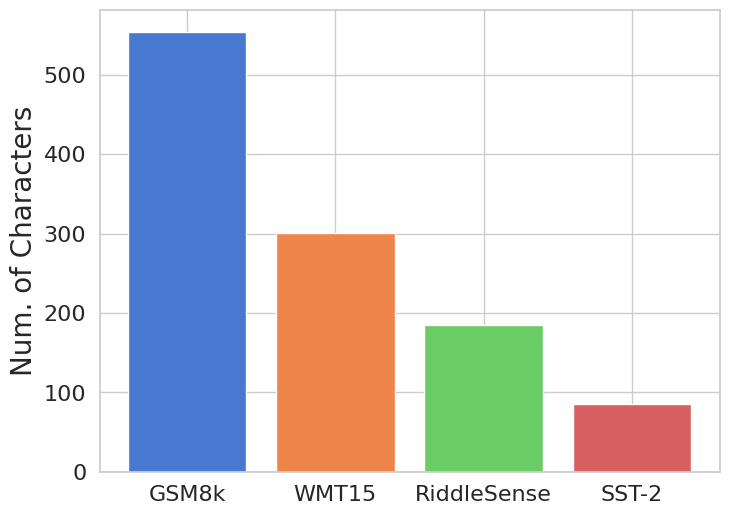

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Apply Seaborn theme
sns.set_theme(style="whitegrid")

# Data for the bar chart
categories = ['GSM8k', 'WMT15',  'RiddleSense', 'SST-2', ] # 'csqa',
values = [554.20, 300.60, 185.10, 85.30] # 184.80,

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=sns.color_palette("muted"))

# Add labels and title
# plt.title('Average Sequence Length of\nFew-shot Examples', fontsize=20)
# plt.xlabel('Categories', fontsize=12)
plt.ylabel('Num. of Characters', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Show the plot
plt.show()


With quantization on TITAN X (12GB):
- Riddle
    Average Latency for 192 samples: 1627.8245833333333 ms
    Average Latency for 181 samples: 394.455359116022 ms
- SST
    Average Latency for 1671 samples: 1352.1416217833614 ms
    Average Latency for 387 samples: 362.50025839793267 ms

On A40:
    GSM8K 150.01,  1420.1
    Riddle 742.9, 139.2
    SST 211.97, 154.86

speed-up:
    9.46670221985201
    5.336925287356322
    1.3687847087692109

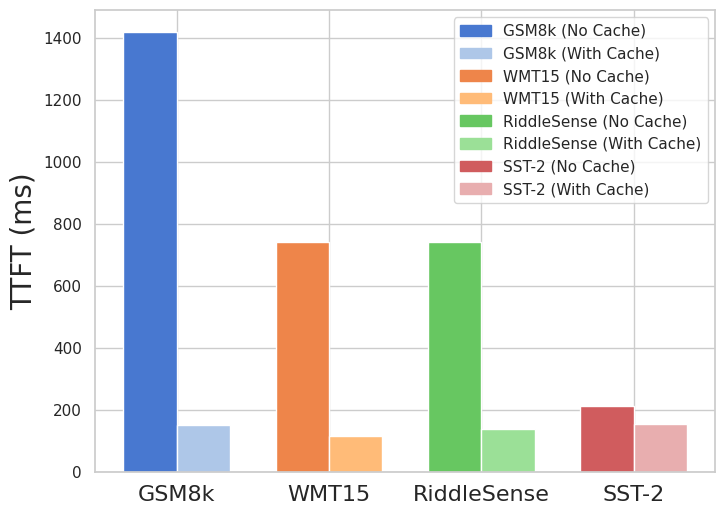

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Categories and values
categories = ['GSM8k', 'WMT15', 'RiddleSense', 'SST-2']
values1 = [1420.1, 742.36, 742.9, 211.97]  # First set of values
values2 = [150.01, 114.42, 139.2, 154.86]  # Second set of values


# Define positions and bar width
x = np.arange(len(categories))  # Positions for bars
width = 0.35  # Width of bars

# Colors with different brightness
colors1 = ['#4878d0', '#ee854a', '#67c761', '#d05c5e']  # Original colors (blue, orange, green)
colors2 = ['#aec7e8', '#ffbb78', '#9be097', '#e8aeaf']  # Lighter versions

# Create the plot
plt.figure(figsize=(8, 6))
plt.bar(x - width/2, values1, width, label='Set 1', color=colors1)
plt.bar(x + width/2, values2, width, label='Set 2', color=colors2)

# Add labels, title, and legend
# plt.title('Latency With and Without Cache', fontsize=20)
# plt.xlabel('Categories', fontsize=12)
plt.ylabel('TTFT (ms)', fontsize=20) # Prefill latency
plt.xticks(x, categories, fontsize=16)
# plt.legend()

# Manually create a legend with all colors
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, color=colors1[0], label='GSM8k (No Cache)'),
    plt.Rectangle((0, 0), 1, 1, color=colors2[0], label='GSM8k (With Cache)'),
    plt.Rectangle((0, 0), 1, 1, color=colors1[1], label='WMT15 (No Cache)'),
    plt.Rectangle((0, 0), 1, 1, color=colors2[1], label='WMT15 (With Cache)'),
    plt.Rectangle((0, 0), 1, 1, color=colors1[2], label='RiddleSense (No Cache)'),
    plt.Rectangle((0, 0), 1, 1, color=colors2[2], label='RiddleSense (With Cache)'),
    plt.Rectangle((0, 0), 1, 1, color=colors1[3], label='SST-2 (No Cache)'),
    plt.Rectangle((0, 0), 1, 1, color=colors2[3], label='SST-2 (With Cache)'),
]
plt.legend(handles=legend_handles, fontsize=11, loc='upper right')

# Show the plot
plt.show()


In [4]:
for v1, v2 in zip(values1, values2):
    print(f'{v1 / v2:.2f}')

9.47
6.49
5.34
1.37


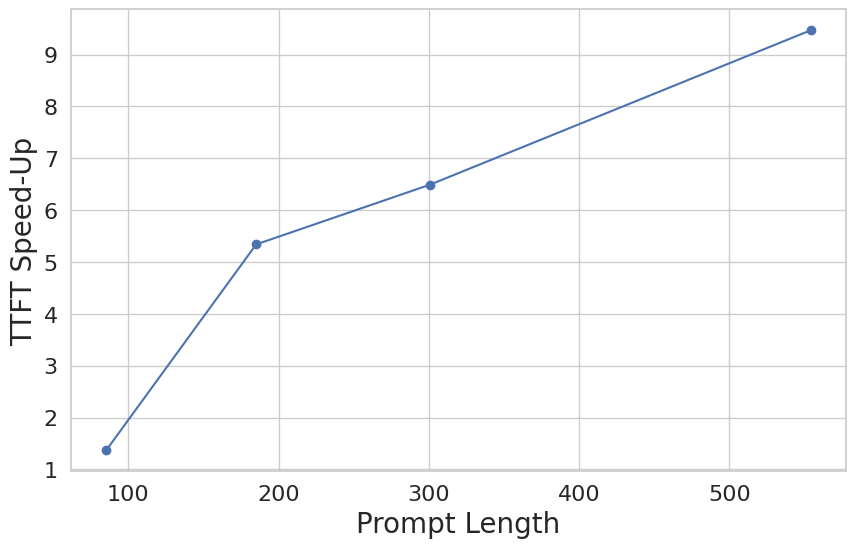

In [19]:
prompt_lenth = [554.20, 300.60, 185.10, 85.30]
speedup = [9.47, 6.49, 5.34, 1.37, ]

# draw a line chart with a trend line
plt.figure(figsize=(10, 6))
plt.plot(prompt_lenth, speedup, marker='o', color='b')
plt.xlabel('Prompt Length', fontsize=20)
plt.ylabel('TTFT Speed-Up', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
